In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)

import optimistix as optx


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *


def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 128
oversample = 4

nwavels = 50
npoly=50#nwavels
n_zernikes = 12

optics = NICMOSOptics(512, wid, oversample, n_zernikes=n_zernikes)

detector = NICMOSDetector(oversample, wid)

In [4]:
spectrum_basis = np.eye(nwavels)
#spectrum_basis = np.load("spectrum_basis.npy")[:,:npoly]

In [5]:
exposures = [
    BlankExposure("test", "F110W", SinglePointFit(spectrum_basis, "F110W"))
] 


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_49423/1389098242.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  BlankExposure("test", "F110W", SinglePointFit(spectrum_basis, "F110W"))


In [6]:
params = {
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)*5#np.zeros(npoly).at[0].set(-np.log10(7336.6235))#np.ones(npoly)*np.log10(7336.6235/nwavels)#(np.arange(npoly)%2 == 1)*0.1+1#jr.uniform(jr.key(1), (nwavels,), minval=-1, maxval=1)#.at[0].set(1)    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

injected_model = set_array(NICMOSModel(exposures, params, optics, detector))

injected_params = ModelParams(params)

In [7]:
injected_params.get("spectrum")

{'test_F110W': Array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],      dtype=float64)}

In [8]:
exposures = [
    #InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e-3, 10)
    InjectedExposure("test", 'F110W', SinglePointFit(spectrum_basis, "F110W"), injected_model, 143.9167, 1)
]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_49423/2028040613.py:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  InjectedExposure("test", 'F110W', SinglePointFit(spectrum_basis, "F110W"), injected_model, 143.9167, 1)


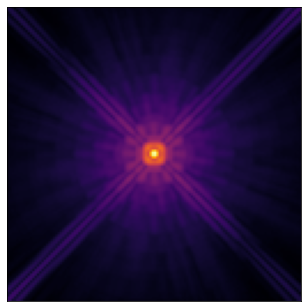

In [9]:
plt.imshow(exposures[0].data**0.125)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [10]:
print(np.sum(exposures[0].data))

4921266.894782092


In [11]:
11811045.472931193/18717.32145868043

631.0222057683178

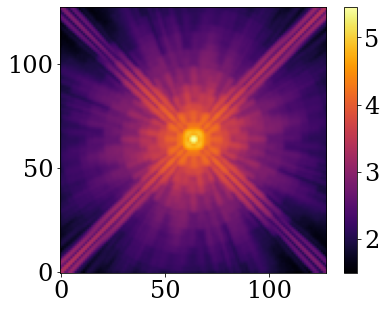

In [12]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

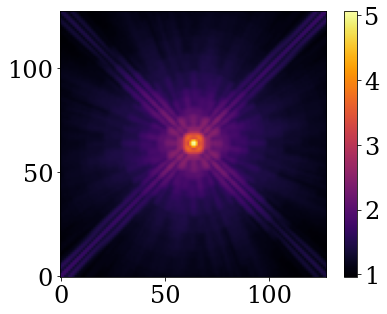

In [13]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [14]:
params = {
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)*5
    #np.zeros(npoly).at[0].set(-np.log10(7336.6235))#np.ones(npoly)*np.log10(7336.6235/nwavels)*100#(np.arange(npoly)%2 == 1)*0.1+1
    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [15]:
model_forecast = injected_params.inject(model)
rc = True
fishers = calc_fishers(model_forecast, exposures, ["spectrum"], fisher_fn, recalculate=True, save=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
np.linalg.cond(fishers["test_F110W.spectrum"])

Array(7656545.28328855, dtype=float64)

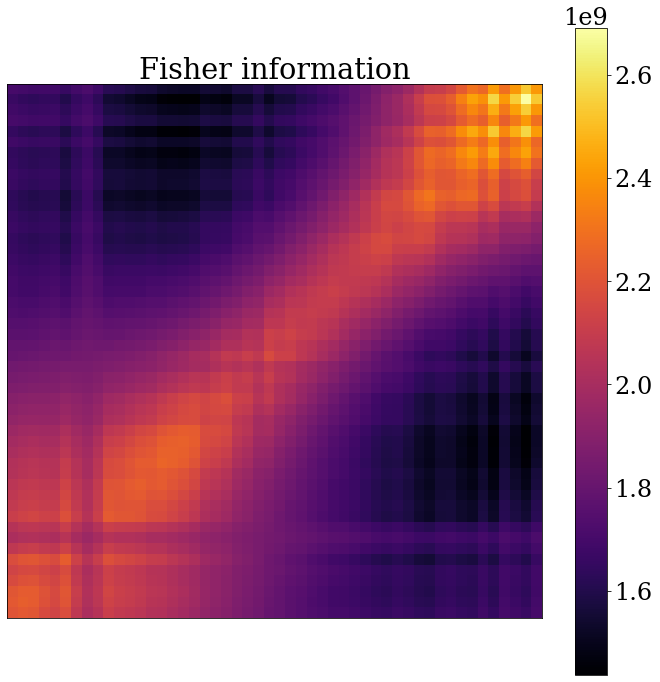

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(fishers["test_F110W.spectrum"], interpolation='none')
plt.title("Fisher information")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()

In [18]:
np.linalg.inv(fishers["test_F110W.spectrum"])

Array([[ 1.10113562e-06, -2.48053116e-06,  2.40990421e-06, ...,
        -9.65114723e-09,  4.01343539e-08, -3.22438675e-08],
       [-2.48053116e-06,  6.63650464e-06, -7.96201103e-06, ...,
         1.72093139e-10,  1.84278843e-09,  2.81683059e-08],
       [ 2.40990421e-06, -7.96201103e-06,  1.23763155e-05, ...,
        -2.43767360e-08,  4.12901170e-08, -6.69561661e-08],
       ...,
       [-9.65114720e-09,  1.72092999e-10, -2.43767356e-08, ...,
         7.93926969e-06, -4.88856430e-06,  1.52713624e-06],
       [ 4.01343539e-08,  1.84278859e-09,  4.12901166e-08, ...,
        -4.88856430e-06,  5.61818035e-06, -2.67656075e-06],
       [-3.22438675e-08,  2.81683058e-08, -6.69561659e-08, ...,
         1.52713624e-06, -2.67656075e-06,  1.54178968e-06]],      dtype=float64)

In [19]:
np.real(np.linalg.eig(fishers['test_F110W.spectrum'])[0].sort()[::-1])

Array([9.19887620e+10, 1.05033582e+10, 4.04801652e+09, 1.43212374e+09,
       9.15064514e+08, 4.97730666e+08, 2.27146337e+08, 1.42114885e+08,
       8.55757846e+07, 4.52323897e+07, 3.26191354e+07, 2.25306891e+07,
       1.29513746e+07, 1.00320741e+07, 7.08798238e+06, 5.49516351e+06,
       4.42447915e+06, 3.07392686e+06, 2.42393747e+06, 1.94019251e+06,
       1.26186167e+06, 1.01372096e+06, 8.65386844e+05, 6.70963467e+05,
       5.03763425e+05, 4.65711492e+05, 3.61857185e+05, 2.98168774e+05,
       2.57846822e+05, 2.12139157e+05, 1.90652184e+05, 1.76871140e+05,
       1.74033844e+05, 1.56402845e+05, 1.48298485e+05, 1.26828510e+05,
       1.19203147e+05, 1.15577951e+05, 1.10015515e+05, 1.04322019e+05,
       9.51392287e+04, 8.57615490e+04, 8.22438374e+04, 8.04117900e+04,
       7.08096984e+04, 6.49674364e+04, 5.99879159e+04, 4.78814721e+04,
       2.93964539e+04, 1.20143953e+04], dtype=float64)

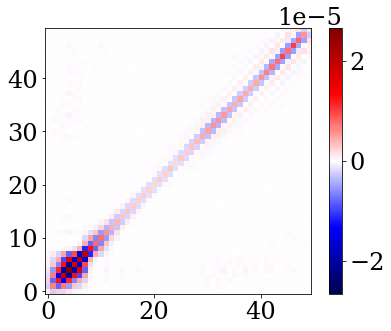

In [20]:
spectrum_cov = np.linalg.inv(fishers['test_F110W.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()

Text(0, 0.5, 'Eigenvalue')

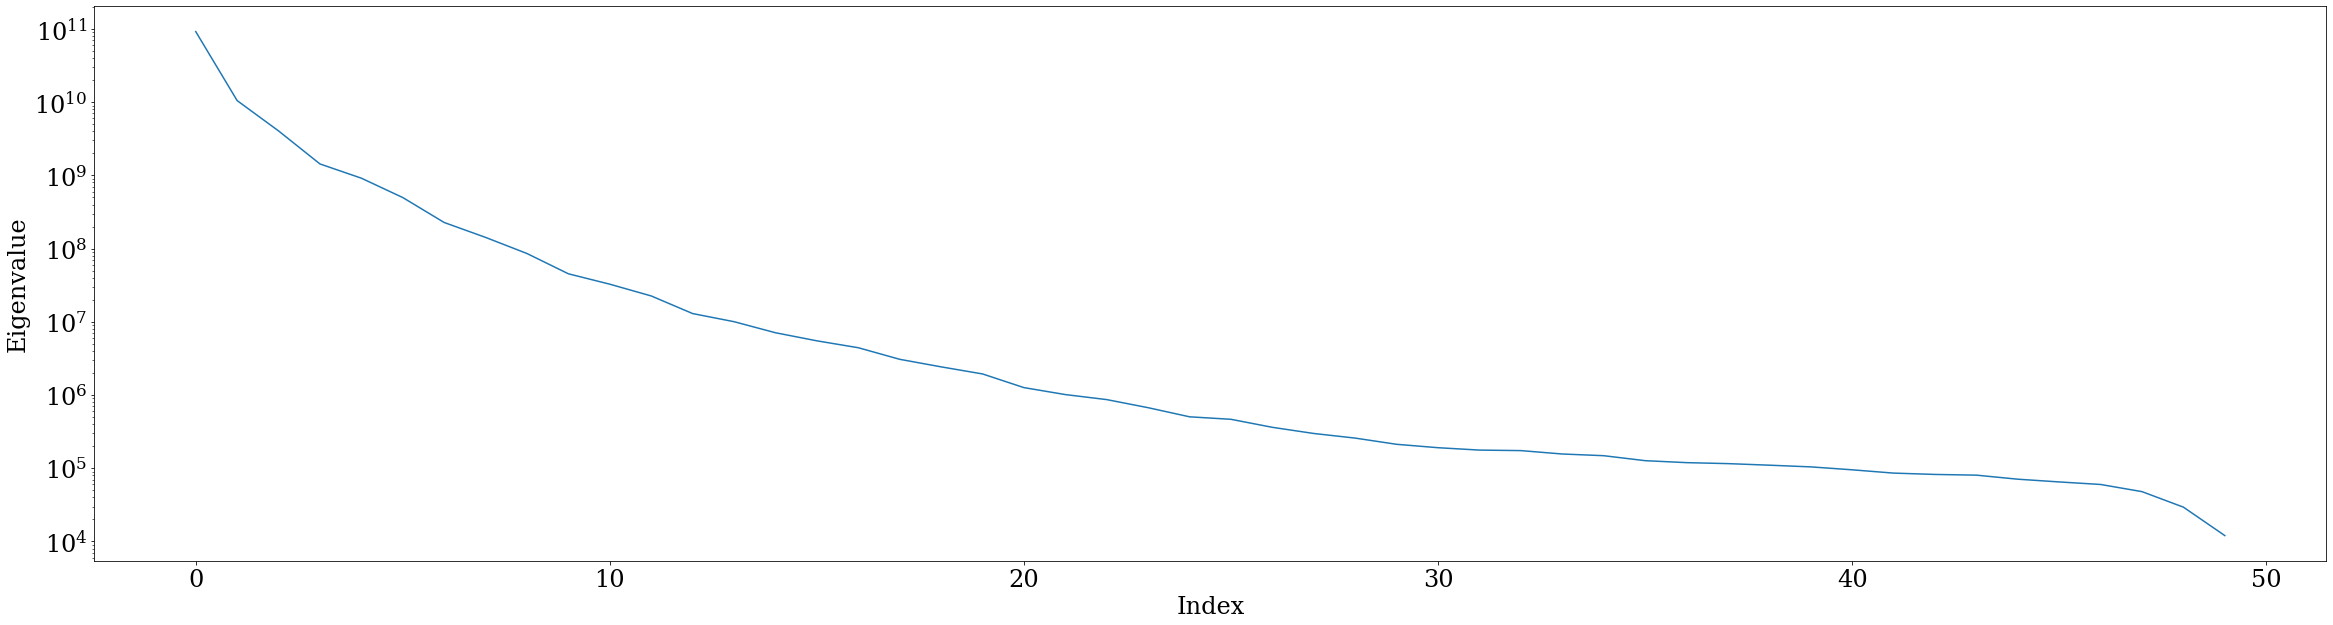

In [21]:
plt.figure(figsize=(40,10))
plt.semilogy(np.real(np.linalg.eig(fishers['test_F110W.spectrum'])[0].sort()[::-1])[:])
plt.xlabel("Index")
plt.ylabel("Eigenvalue")

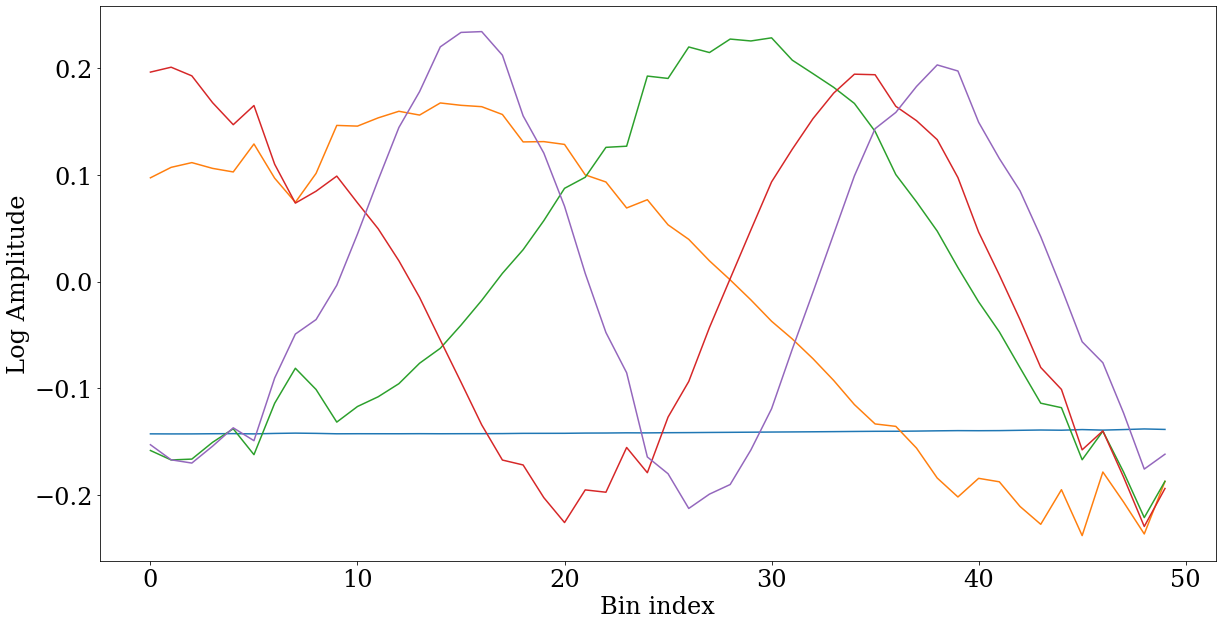

In [22]:
vals, vects = np.linalg.eig(fishers['test_F110W.spectrum'])

order = np.argsort(vals)[::-1]

plt.figure(figsize=(20,10))
plt.xlabel("Bin index")
plt.ylabel("Log Amplitude")

for i in range(5):
    plt.plot(np.real(vects[:,order[i]]))

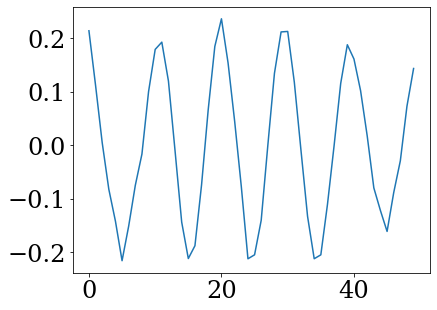

In [23]:
plt.plot(np.real(vects[:,order[10]]))

In [31]:
vcts = np.real(vects[:,order])
vects_adj = vcts*np.ones(nwavels).at[0].mul(-1)
numpy.save("spectrum_basis.npy", np.real(vects_adj))

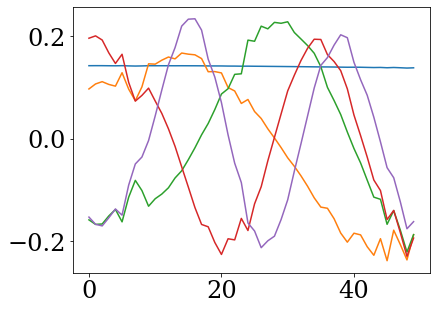

In [30]:
for i in range(5):
    plt.plot(np.real(vects_adj[:,i]))

In [25]:
stop

NameError: name 'stop' is not defined

In [ ]:
params = {
    "positions": {},
    "spectrum": {},
    "flux": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {},
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.0,0.0])#positions_dict[exp.fit.get_key(exp, "positions")]#np.asarray(positions[idx])#np.asarray([0.49162114, -0.5632928])#np.asarray([ 0.45184505, -0.8391668 ])#np.asarray([-0.2,0.4])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[1].set(1).at[2].set(1)#((np.arange(npoly)%2 == 1)*0.1+0.95)
    params["flux"][exp.fit.get_key(exp, "flux")] = np.log10(np.nansum(exp.data))#(np.arange(npoly)%2 == 1)*0.1+1




    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    params["bias"][exp.fit.get_key(exp, "bias")] = 0.

model_single = set_array(NICMOSModel(exposures, params, optics, detector))


params = ModelParams(params)

In [ ]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.rmsprop(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))





def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "flux": opt(g*3,5),
    "spectrum": opta(0.1, 15),#, (20, 1.5)),
    #"cold_mask_shift": opt(g*10, 30),
    #"cold_mask_rot": opt(g*10, 100),
    #"bias": opt(g*2, 20),
    #"aberrations": opt(g*1, 100),

    #"cold_mask_scale": opt(g*1, 300),
    #"cold_mask_shear": opt(g*1, 300),
    #"primary_scale": opt(g*1, 300),
    #"primary_shear": opt(g*1, 300),
}

things_start = {
    "positions": opt(g*5, 0),
}

groups = list(things.keys())

In [ ]:
losses, models = optimise(params, model_single, exposures, things, 40, recalculate=True)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

{'test_F110W.positions': Array([[ 6.04146253e+09, -4.21694456e+07],
       [-4.21694456e+07,  6.04258558e+09]], dtype=float64), 'test_F110W.flux': Array([[3.1829236e+10]], dtype=float64), 'test_F110W.spectrum': Array([[8.49576510e+08, 4.34123169e+08, 2.88624541e+08, 7.02817482e+08,
        2.97826799e+08],
       [4.34123169e+08, 1.67558214e+08, 1.71809397e+08, 3.51539317e+08,
        1.05229925e+08],
       [2.88624541e+08, 1.71809397e+08, 4.82229453e+07, 2.44862850e+08,
        9.63341906e+07],
       [7.02817482e+08, 3.51539317e+08, 2.44862850e+08, 5.30719276e+08,
        2.52751813e+08],
       [2.97826799e+08, 1.05229925e+08, 9.63341906e+07, 2.52751813e+08,
        8.68496200e+06]], dtype=float64)}
Fitting Model


  0%|          | 0/40 [00:00<?, ?it/s]

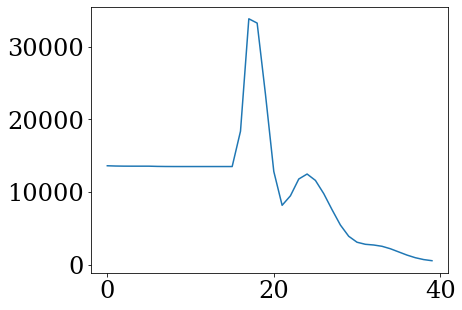

In [ ]:
plt.plot(np.asarray(losses[:])/(len(exposures)*wid**2))

3
11.99547873677277


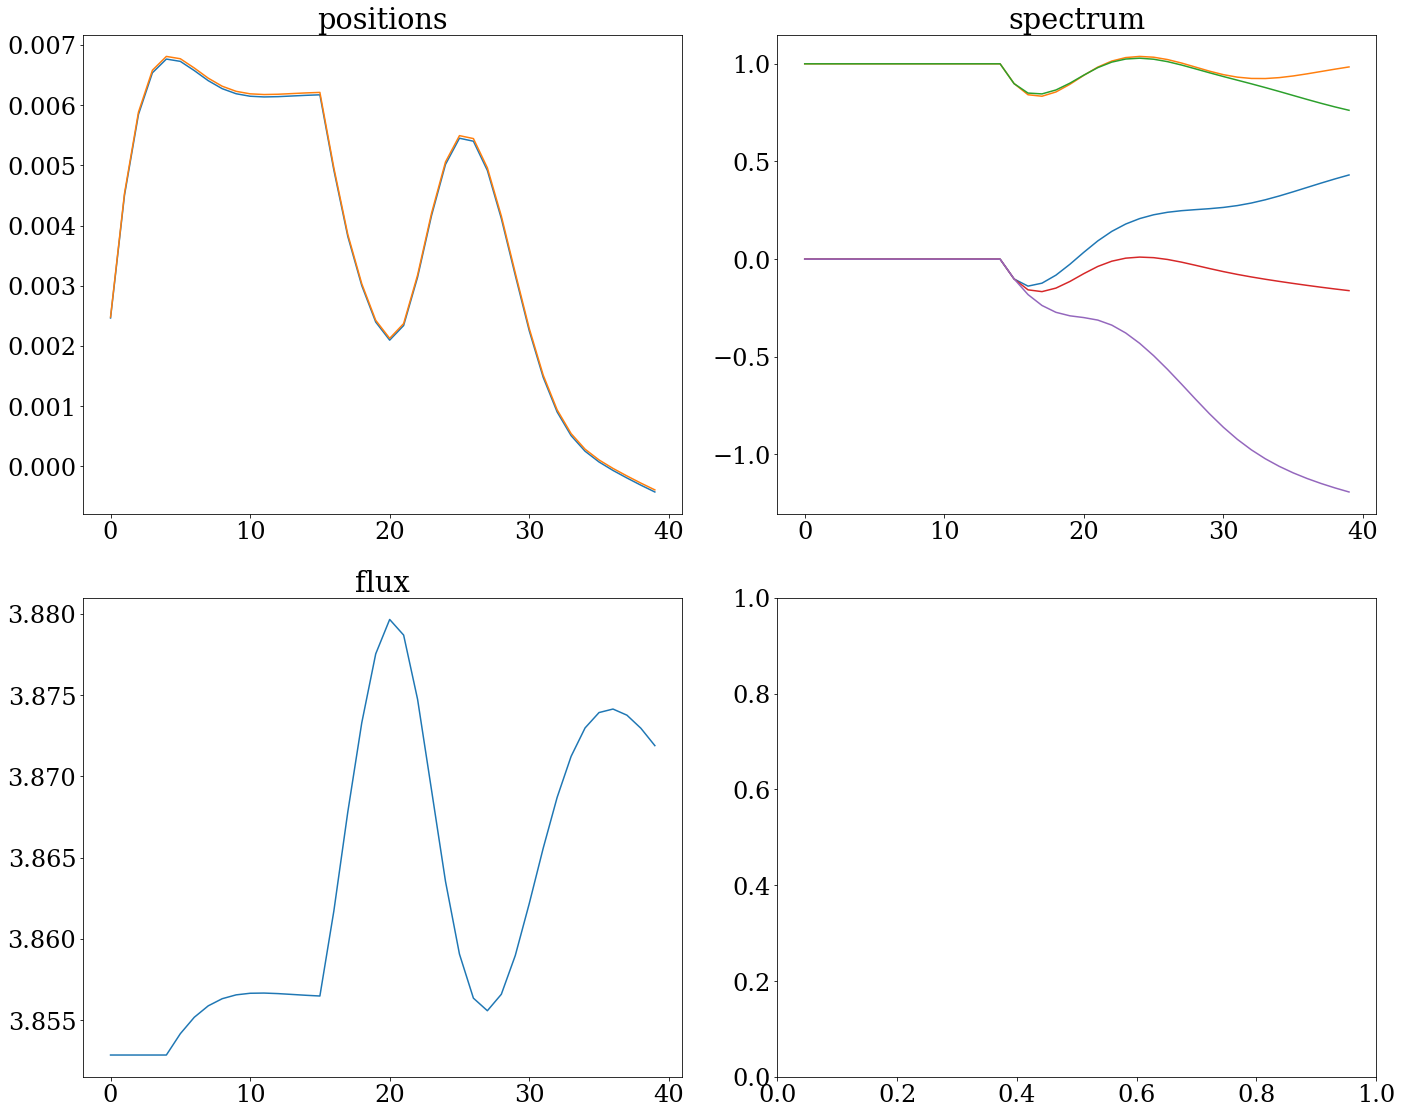

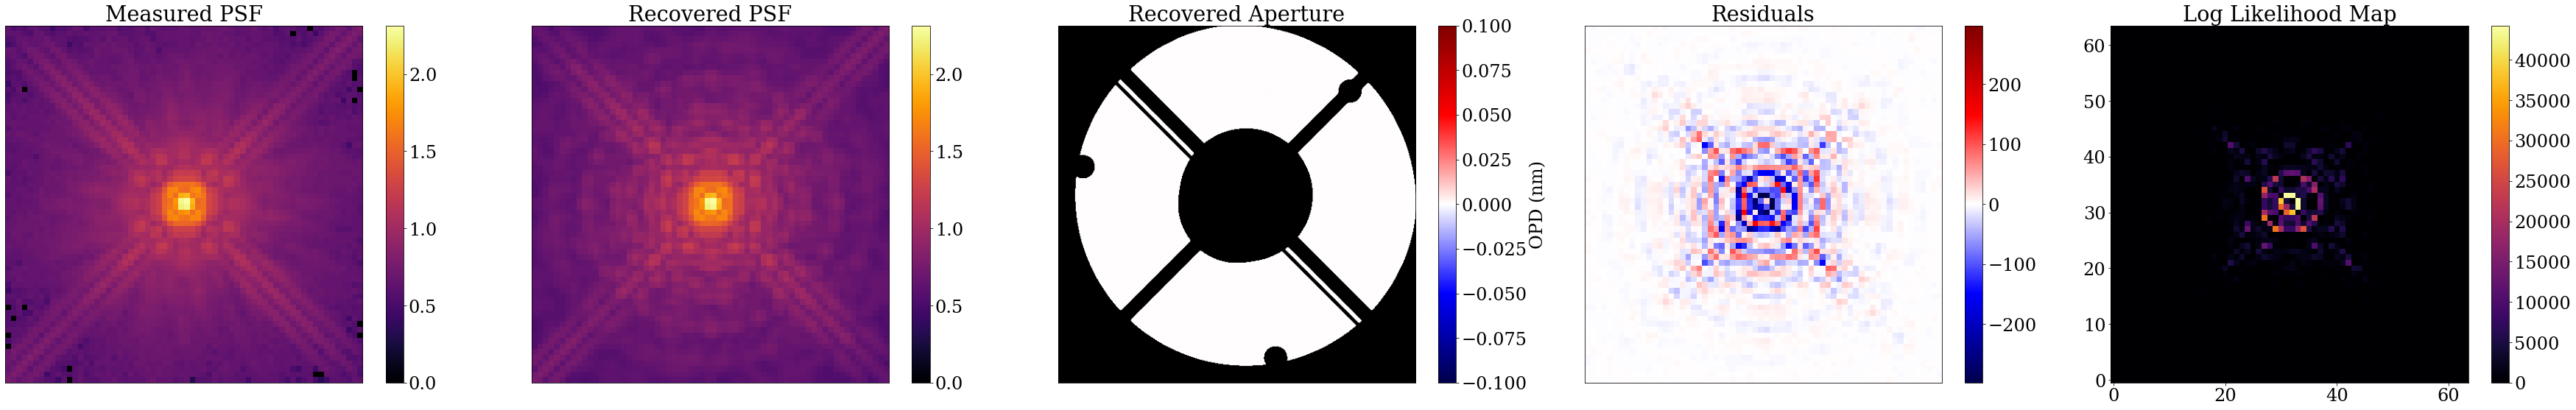

In [ ]:
plot_params(models, groups, xw = 2)
plot_comparison(model_single, models[-1], exposures)

In [ ]:
models[-1].params

{'flux': {'test_F110W': Array(3.87189172, dtype=float64)},
 'positions': {'test_F110W': Array([-0.00042612, -0.00039126], dtype=float64)},
 'spectrum': {'test_F110W': Array([ 0.43097004,  0.98399601,  0.76203626, -0.16124891, -1.19195222],      dtype=float64)}}

In [ ]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-6, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [ ]:
#sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures, things, 5000)
#print(sol.value.params)
#print(fun(sol.value, (exposures, model_single)), (losses[-1]))

In [ ]:
#final_params = sol.value
final_params = models[-1]

In [ ]:
fsh = calc_fishers(final_params.inject(model_single), exposures, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/1 [00:00<?, ?it/s]

{'test_F110W.spectrum': Array([[ 4.24438474e+08,  2.45890170e+08, -3.21868598e+07,
         -5.29023942e+07,  8.45165719e+07],
        [ 2.45890170e+08,  1.67266766e+08, -1.94384597e+07,
         -5.75784306e+06,  6.87216556e+07],
        [-3.21868598e+07, -1.94384597e+07,  1.48929015e+07,
          1.13641515e+07,  4.14793235e+06],
        [-5.29023942e+07, -5.75784306e+06,  1.13641515e+07,
          3.69643180e+07,  1.55262082e+07],
        [ 8.45165719e+07,  6.87216556e+07,  4.14793235e+06,
          1.55262082e+07,  4.19164435e+07]], dtype=float64)}

In [ ]:
np.max(fsh['test_F110W.spectrum'])/np.min(fsh['test_F110W.spectrum'])

Array(-8.0230485, dtype=float64)

In [ ]:
spectrum_cov = np.linalg.inv(fsh['test_F110W.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

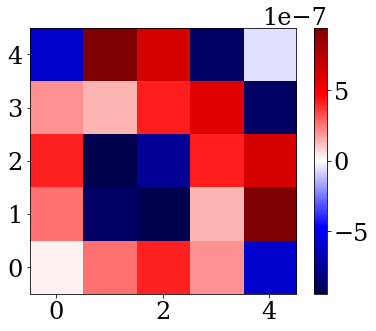

In [ ]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()

Text(0.5, 0, 'Wavelength (um)')

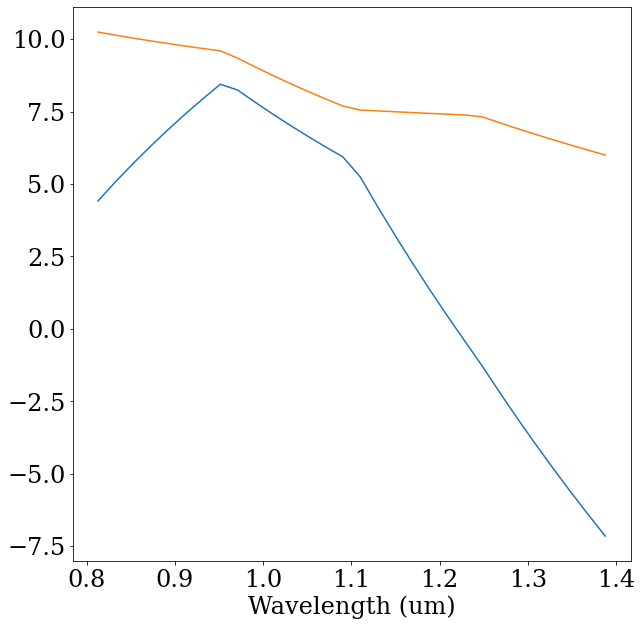

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

spec = CombinedBinnedSpectrum(wv, filt, final_params.get("spectrum.test_F110W"))

spec2 = CombinedBinnedSpectrum(wv, filt, (np.arange(npoly)%2 == 1)*0.1+1)


#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv*1e6, spec.spec_weights()*spec.flux/(wv*1e6))#, yerr = spectrum_err)
plt.plot(wv*1e6, spec2.spec_weights()*spec.flux/(wv*1e6))#, yerr = spectrum_err)

plt.xlabel("Wavelength (um)")


In [ ]:
spectrum_cov

Array([[ 2.43271744e-08,  2.65629413e-07,  4.12782788e-07,
         2.01289397e-07, -5.99955446e-07],
       [ 2.65629413e-07, -8.77314689e-07, -9.36881749e-07,
         1.34301393e-07,  9.45723395e-07],
       [ 4.12782788e-07, -9.36881749e-07, -7.53532721e-07,
         4.14000739e-07,  6.24929446e-07],
       [ 2.01289397e-07,  1.34301393e-07,  4.14000739e-07,
         5.79030632e-07, -8.81494181e-07],
       [-5.99955446e-07,  9.45723395e-07,  6.24929446e-07,
        -8.81494181e-07, -5.22802642e-08]], dtype=float64)

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_79014/1157409694.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.test_F110W"), spectrum_cov)


Text(0, 0.5, 'Flux')

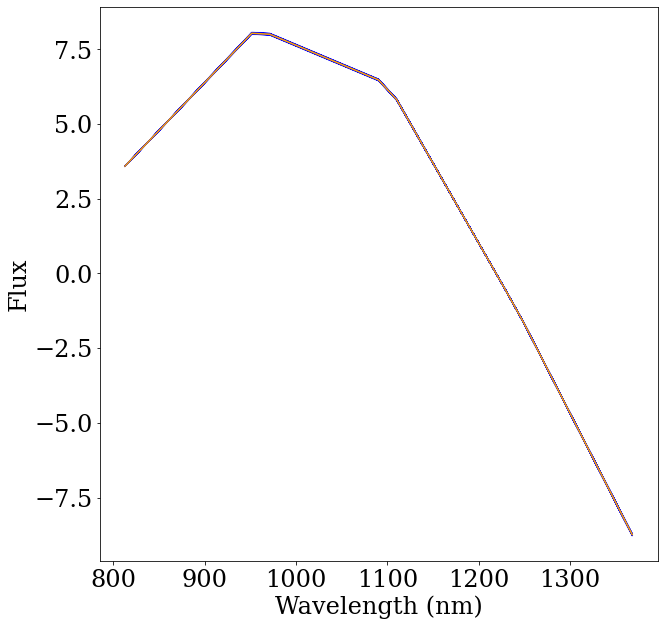

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='orange')
for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.test_F110W"), spectrum_cov)
    spec = CombinedBinnedSpectrum(wv, filt, coeffs)
    plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='b', alpha=0.01, zorder=0)
    #plt.plot(wv*1e9, spec.spec_weights()*spec.flux, color='b', alpha=0.01, zorder=0)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")
